In [2]:
from collections import defaultdict
import requests
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime, timedelta, time
from urllib.error import HTTPError
import statistics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#
cur_working_directiory = os.getcwd()
# Change 
os.chdir("../../Data/")


CSVfiles = []
for file in os.listdir("./"):
  if file.endswith(".csv"):
    CSVfiles.append(file)
print(CSVfiles)


unixTimeConverter = lambda x : (datetime.fromtimestamp(x)).strftime('%Y-%m-%d %H:%M:%S')
unixTimeConverterNoDateJustTime = lambda x: (datetime.fromtimestamp(x) - timedelta(hours=4)).time()


allDfs = []


for x in CSVfiles:

  dfTemp = pd.read_csv(x)
  dfTemp['estTime']  = dfTemp['time'].apply(unixTimeConverter)
  dfTemp['timeOnly'] = dfTemp['time'].apply(unixTimeConverterNoDateJustTime)

  dfTemp['candleHeight']  = dfTemp.apply( lambda row:    max(row['open'],  row['close']) - min(row['open'],  row['close']), axis = 1 )
  allDfs.append(dfTemp)

df = allDfs[1]
#This is for generating if profit
for i in range(1, 15):
  df['P/L' +str(i) +'Short_']  = ( df['close'] - df['close'].shift(-i) )
  df['P/L' +str(i) +'Long_']  =  (  df['close'].shift(-i) - df['close']     )
  df['P/L' +str(i) +'Short']  = ( df['close'] - df['close'].shift(i) )
  df['P/L' +str(i) +'Long']  =  (  df['close'].shift(i) - df['close']     )

df = df.tail(-15)


os.chdir(cur_working_directiory)
print(df.shape)
df.head()

['OANDA EURUSD, 5(2).csv', 'BATS AAPL, 30.csv', 'OANDA EURUSD, 240(1).csv', 'OANDA EURUSD, 60(3).csv', 'OANDA EURUSD, 30(4).csv']
(11157, 71)


,time,open,high,low,close,Volume,Volume MA,RSI,RSI-based MA,Upper Bollinger Band,...,P/L12Short,P/L12Long,P/L13Short_,P/L13Long_,P/L13Short,P/L13Long,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long
15,1581624000,81.51750,81.5450,81.2175,81.3000,435948,580956.6,53.852744,57.807161,NaN,...,-0.5000,0.5000,0.3725,-0.3725,-0.0475,0.0475,0.0650,-0.0650,-0.0200,0.0200
16,1581625800,81.30750,81.3175,81.1075,81.2575,812596,598122.2,52.841151,56.952776,NaN,...,0.1100,-0.1100,0.0225,-0.0225,-0.5425,0.5425,1.8225,-1.8225,-0.0900,0.0900
17,1581690600,81.20125,81.4900,80.8800,80.9875,728884,600546.6,46.823568,55.183338,NaN,...,-0.0100,0.0100,1.5525,-1.5525,-0.1600,0.1600,1.8425,-1.8425,-0.8125,0.8125
18,1581692400,80.96000,81.2400,80.7150,81.2300,618508,600716.2,52.099755,54.970054,NaN,...,-0.1025,0.1025,2.0850,-2.0850,0.2325,-0.2325,1.7800,-1.7800,0.0825,-0.0825
19,1581694200,81.22750,81.4825,81.1575,81.4275,552908,613591.6,55.934527,55.243179,NaN,...,0.1000,-0.1000,1.9775,-1.9775,0.0950,-0.0950,2.1825,-2.1825,0.4300,-0.4300


In [3]:
d_counts_average_vol            = defaultdict(list)
d_counts_average_highLow_diff   = defaultdict(list)


closeOpenDeltaList = []
closeOpenDeltaList_ = []
openLowDeltaList = []
highLowDeltaList = []

for index, row in df.iterrows():
  closeOpenDeltaList.append(abs(row['close'] - row['open']))
  closeOpenDeltaList_.append(row['close'] - row['open'])
  openLowDeltaList.append(abs(row['open'] - row['low']))
  highLowDeltaList.append(row['high'] - row['low'])


df1 = pd.DataFrame({'closeOpenDelta': closeOpenDeltaList, 'CloseOpenDelta_': closeOpenDeltaList_, 'openLowDelta': openLowDeltaList, 'highLowDelta': highLowDeltaList})

# df2 = pd.concat([df, df1])

df2 = pd.concat([df.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
print("mnath should add up")
print(df.shape)
print(df1.shape)
print(df2.shape)
df= df2

for index, row in df.iterrows():
  #put volumes in d
  time_  = str(row['timeOnly'])
  volume = row['Volume']
  d_counts_average_vol[str(time_)].append(volume)


  #Collecting, using a dictionary of lists to collect the price deltas for each time
  price_delta = row['closeOpenDelta']
  d_counts_average_highLow_diff[str(time_)].append(price_delta)

df.head()

###############################################
##THIS use to be seperate cells, but now I just combined them
##
################################################
import statistics

std_values_with_time_as_keys = {}
mean_values_with_time_as_keys = {}

#for volume
std_values_with_time_as_keys_volume = {}
mean_values_with_time_as_keys_volume = {}

for k , v in d_counts_average_highLow_diff.items():

  # Calculate mean and standard deviation of the sample for price delta
  mean = statistics.mean(v)
  std_dev = statistics.stdev(v)
  std_values_with_time_as_keys[k] = std_dev
  mean_values_with_time_as_keys[k] = mean

for k , v in d_counts_average_vol.items():
  # Calculate mean and standard deviation of the sample of volume
  mean__ = statistics.mean(v)
  std_dev__ = statistics.stdev(v)
  std_values_with_time_as_keys_volume[k] = std_dev__
  mean_values_with_time_as_keys_volume[k] = mean__


z_score_list = []
z_score_volume_list = []

for index, row in df.iterrows():
  time_  = str(row['timeOnly'])
  mean_ = mean_values_with_time_as_keys[time_]
  std_ = std_values_with_time_as_keys[time_]

  cur_val = row['closeOpenDelta']
  z_score_list.append(( cur_val - mean)/ std_)
  # row['z-score'] = (row['closeOpenDelta'] - mean)/ std_
  
  mean_ = mean_values_with_time_as_keys_volume[time_]
  std_ = std_values_with_time_as_keys_volume[time_]
  z_score_volume_list.append((row['Volume'] - mean)/ std_)

df['z-score']= z_score_list 
df['z-score-volume']= z_score_volume_list


df.head(1)


mnath should add up
(11157, 71)
(11157, 4)
(11157, 75)


,time,open,high,low,close,Volume,Volume MA,RSI,RSI-based MA,Upper Bollinger Band,...,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long,closeOpenDelta,CloseOpenDelta_,openLowDelta,highLowDelta,z-score-volume,z-score
0,1581624000,81.5175,81.545,81.2175,81.3,435948,580956.6,53.852744,57.807161,NaN,...,0.065,-0.065,-0.02,0.02,0.2175,-0.2175,0.3,0.3275,1.26087,-0.344982


In [4]:
""" 
This is a split test, curious to see if having a 
low openLowDelta, along with a 4+ z-score, will
increase a higher profitablity rate.
"""

totalProfShort = defaultdict(float)
totalProfLong  = defaultdict(float)
totalPro       = defaultdict(float)

#Note this is actually shorting, I am doing the opposite of the 
#Large directional move, hence mean reversion
totalProfLongList = defaultdict(list)
#Comparing this 
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata = defaultdict(list)
totalProfLongWithLowOpenLowDelta      = defaultdict(float)
#
#to see if only buy when the open and low are FAR away
totalProfLongListWithHighOpenLowDelata = defaultdict(list)
totalProfLongWithHighOpenLowDelta      = defaultdict(float)
#
#volume filter
totalProfLongListWithHighVolume = defaultdict(list)
totalProfLongWithHighVolume      = defaultdict(float)
totalProfLongListWithLowVolume = defaultdict(list)
totalProfLongWithLowVolume      = defaultdict(float)
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata_filter_big_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_big_moves      = defaultdict(float)
# filter for only the largest moves
totalProfLongListWithLowOpenLowDelata_filter_most_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_most_moves      = defaultdict(float)


# With Stop Losses
totalProfLongListStopLoss = defaultdict(list)
totalProfLongStopLoss  = defaultdict(float)



# With Stop Losses
totalProfLongListStopLoss_RSI_high = defaultdict(list)
totalProfLongStopLoss_RSI_high  = defaultdict(float)


# With Stop Losses
totalProfLongList_RSI_Volume = defaultdict(list)
totalProfLong_RSI_Volume  = defaultdict(float)


# With Stop Losses
totalProfLongList_RSI_Volume_spreadLowOpen = defaultdict(list)
totalProfLong_RSI_Volume_spreadLowOpen  = defaultdict(float)


# allBigSDMoves
for index, row in df.iterrows():
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      for i in range(1,15):
        lookup = 'P/L' + str(i) +'Short'
        totalProfLong[lookup] +=row[lookup]
        totalProfLongList[lookup].append(row[lookup])
        #print(row['CloseOpenDelta_'])
        if row['openLowDelta'] <= 0.00006:
          totalProfLongWithLowOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata[lookup].append(row[lookup])
        if row['openLowDelta'] > 0.00006:
          totalProfLongWithHighOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithHighOpenLowDelata[lookup].append(row[lookup])
        if row['z-score-volume'] >= 2:
          totalProfLongWithHighVolume[lookup] +=row[lookup]
          totalProfLongListWithHighVolume[lookup].append(row[lookup])
        if row['z-score'] <= 4:
          totalProfLongListWithLowOpenLowDelata_filter_big_moves[lookup].append(row[lookup])
          totalProfLongWithLowOpenLowDelta_filter_big_moves[lookup] +=row[lookup]
        if row['z-score'] >= 4.2:
          totalProfLongWithLowOpenLowDelta_filter_most_moves[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata_filter_most_moves[lookup].append(row[lookup])
        if row['RSI'] < 80:
          totalProfLongListStopLoss_RSI_high[lookup].append(row[lookup])
          totalProfLongStopLoss_RSI_high[lookup] +=row[lookup]
        if row['RSI'] < 80 and row['z-score-volume'] >= 2:
          totalProfLongList_RSI_Volume[lookup].append(row[lookup])
          totalProfLong_RSI_Volume[lookup] +=row[lookup]
        if row['RSI'] < 80 and row['z-score-volume'] >= 2 and row['openLowDelta'] > 0.00006:
          totalProfLongList_RSI_Volume_spreadLowOpen[lookup].append(row[lookup])
          totalProfLong_RSI_Volume_spreadLowOpen[lookup] +=row[lookup]

        
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      bought_value = row['close']
      for i in range(1,10):
        stopLoss = 0.003
        lookup = 'P/L' + str(i) +'Short'
        if df.iloc[index+i]['high'] - bought_value > stopLoss:
          totalProfLongStopLoss[lookup] -= stopLoss
          totalProfLongListStopLoss[lookup].append(-stopLoss)
          break
        else:
          totalProfLongStopLoss[lookup] += row[lookup]
          totalProfLongListStopLoss[lookup].append(row[lookup])



  
      


###################
#Print Stats

def whoIsLargest(a,b,c,d):
  if a > b and a > c and a > d:
    return "no filter"
  if b > a and b > c and b > d:
    return "small open low delta"
  if c > a and c > b and c > d:
    return "large open low delta"
  if d > a and d > b and d > c:
    return "high volume"
  return "all are equal"
def whoIsSmallest(a,b,c,d):
  if a < b and a < c and a < d:
    return "no filter"
  if b < a and b < c and b < d:
    return "small open low delta"
  if c < a and c < b and c < d:
    return "large open low delta"
  if d < a and d < b and d < c:
    return "high volume"
  return "all are equal"
  
# for k, v in totalProfLong.items():
#   print(k, "any z-score", v, "filtered out with only low open low delta", totalProfLongWithLowOpenLowDelta[k], "diff", v - totalProfLongWithLowOpenLowDelta[k])

#Note total doesn't seem to matter much because the filters force less trades
for k, v in totalProfLongList.items():
  print("--------------------")
  print(k, "first is no filter, second is filtered out with only low open low delta")
  print(  "mean",  sum(v)/len(v), "std", statistics.stdev(v), "median", statistics.median(v), "max", max(v), "min", min(v), "total", sum(v))
  print(  "mean",  sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata[k]), "max", max(totalProfLongListWithLowOpenLowDelata[k]), "min", min(totalProfLongListWithLowOpenLowDelata[k]), )
  print(  "mean",  sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithHighOpenLowDelata[k]), "max", max(totalProfLongListWithHighOpenLowDelata[k]), "min", min(totalProfLongListWithHighOpenLowDelata[k]))
  print(  "mean",  sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]), "std", statistics.stdev(totalProfLongListWithHighVolume[k]), "median", statistics.median(totalProfLongListWithHighVolume[k]), "max", max(totalProfLongListWithHighVolume[k]), "min", min(totalProfLongListWithHighVolume[k]) )
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]))
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]))
  
  if len(totalProfLongListStopLoss[k]) > 0 : print( "mean",  sum(totalProfLongListStopLoss[k])/len(totalProfLongListStopLoss[k]), "std", statistics.stdev(totalProfLongListStopLoss[k]), "median", statistics.median(totalProfLongListStopLoss[k]), "max", max(totalProfLongListStopLoss[k]), "min", min(totalProfLongListStopLoss[k]))
  print("mean", sum(totalProfLongListStopLoss_RSI_high[k])/len(totalProfLongListStopLoss_RSI_high[k]), "std", statistics.stdev(totalProfLongListStopLoss_RSI_high[k]), "median", statistics.median(totalProfLongListStopLoss_RSI_high[k]), "max", max(totalProfLongListStopLoss_RSI_high[k]), "min", min(totalProfLongListStopLoss_RSI_high[k]))
  # mean_ = whoIsLargest(sum(v)/len(v), sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]))
  # std_  = whoIsSmallest(statistics.stdev(v), statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighVolume[k]))
  # print("winners", "---mean---" , mean_, "---std---", std_)
# 
# print(len(totalProfLongList))

#plots

                                                     
# "total", sum(totalProfLongListWithLowOpenLowDelata[k]) ,                
# "total", ,               
#  ,                      
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]) 
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])


import inspect

def print_variable_name(var):
    # Get the current frame
    current_frame = inspect.currentframe()

    # Get the caller's frame (the frame where the function is called)
    caller_frame = current_frame.f_back

    # Get the caller's local variables dictionary
    local_vars = caller_frame.f_locals

    # Find the variable name by searching for its value in the local variables
    var_name = [name for name, value in local_vars.items() if value is var][0]

    # Print the variable name and its value
    print(f"Variable name: {var_name}, Value: {var}")

--------------------
P/L1Short first is no filter, second is filtered out with only low open low delta
mean 2.040078947368421 std 1.2957577289390405 median 1.8599999999999852 max 6.310000000000002 min -3.6500000000000057 total 193.80749999999998
mean 1.9175000000000075 std 0.6191872553136564 median 1.7600000000000051 max 3.3000000000000114 min 1.1500000000000057
mean 2.0513505747126426 std 1.3425499538472465 median 1.8600000000000136 max 6.310000000000002 min -3.6500000000000057
mean 2.182440476190477 std 1.7449334748741427 median 1.9699999999999989 max 6.310000000000002 min -3.6500000000000057
mean 1.7982894736842099 std 1.2701657440614673 median 1.6899999999999977 max 6.310000000000002 min -3.6500000000000057
mean 2.459857142857143 std 1.3026989718828077 median 2.3799999999999955 max 4.219999999999999 min -3.6499999999999773
mean 0.07972105263157876 std 0.5686099685729945 median -0.003 max 4.212500000000006 min -0.003
mean 2.001620879120879 std 1.2985523656506865 median 1.85500000000

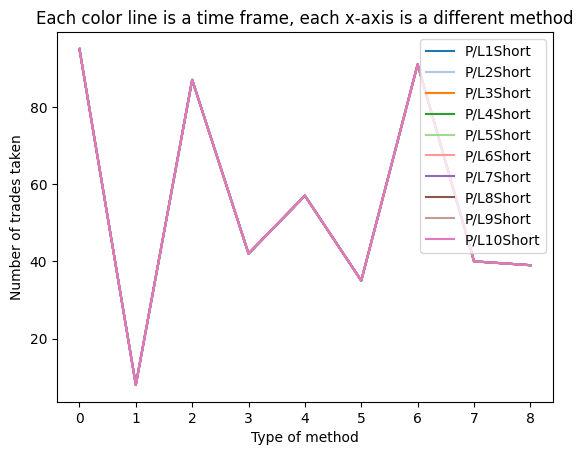

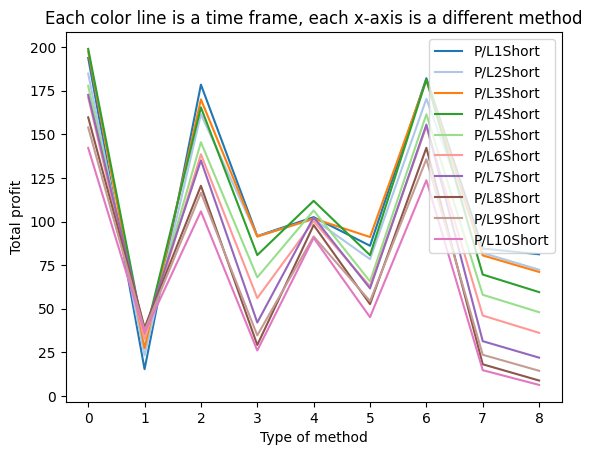

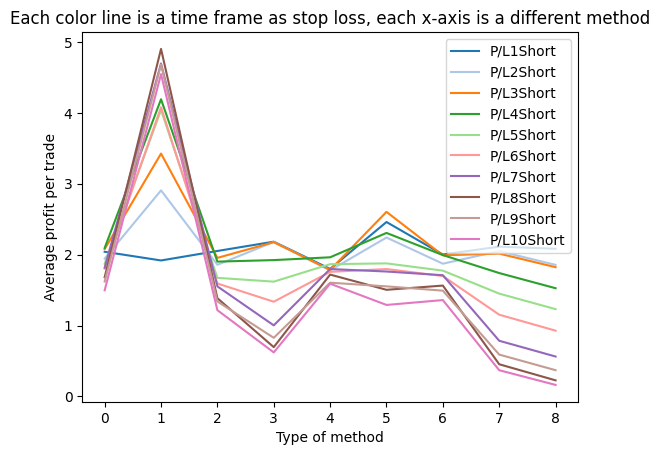

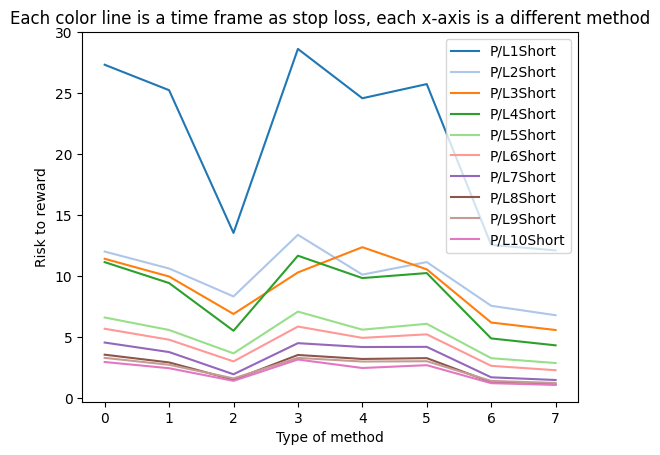

In [7]:
import numpy as np

colors = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
colors = plt.cm.tab20(np.linspace(0, 1, 15))
i = 0
# Plot each array with a different color
for k, v in totalProfLongList.items():

    t1 = len(v)
    t2 = len(totalProfLongListWithLowOpenLowDelata[k])
    t3 = len(totalProfLongListWithHighOpenLowDelata[k])
    t4 = len(totalProfLongListWithHighVolume[k])
    t5 = len(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])
    t6 = len(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])
    t7 = len(totalProfLongListStopLoss_RSI_high[k])
    t8 = len(totalProfLongList_RSI_Volume[k])
    t9 = len(totalProfLongList_RSI_Volume_spreadLowOpen[k])  
    data = [t1, t2, t3, t4, t5, t6, t7, t8, t9]
    plt.plot(data, color=colors[i], label=k)
    i += 1
    if i > 9: break

# Customize the plot
plt.xlabel('Type of method')
plt.ylabel('Number of trades taken')
plt.title('Each color line is a time frame, each x-axis is a different method')
plt.legend()

# Show the plot
plt.show()

#########################



i = 0
# Plot each array with a different color
for k, v in totalProfLongList.items():

    t1 = sum(v)
    t2 = sum(totalProfLongListWithLowOpenLowDelata[k])
    t3 = sum(totalProfLongListWithHighOpenLowDelata[k])
    t4 = sum(totalProfLongListWithHighVolume[k])
    t5 = sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])
    t6 = sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])
    t7 = sum(totalProfLongListStopLoss_RSI_high[k])
    t8 = sum(totalProfLongList_RSI_Volume[k])
    t9 = sum(totalProfLongList_RSI_Volume_spreadLowOpen[k])  
    data = [t1, t2, t3, t4, t5, t6, t7, t8, t9]
    plt.plot(data, color=colors[i], label=k)
    i += 1
    if i > 9: break

# Customize the plot
plt.xlabel('Type of method')
plt.ylabel('Total profit')
plt.title('Each color line is a time frame, each x-axis is a different method')
plt.legend()

# Show the plot
plt.show()




colors = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
colors = plt.cm.tab20(np.linspace(0, 1, 15))

i =0 
# Plot each array with a different color
for k, v in totalProfLongList.items():

    t1 = sum(v)/len(v)
    t2 = sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k])
    t3 = sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k])
    t4 = sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k])
    t5 = sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])
    t6 = sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])
    t7 = sum(totalProfLongListStopLoss_RSI_high[k])/len(totalProfLongListStopLoss_RSI_high[k])
    t8 = sum(totalProfLongList_RSI_Volume[k])/len(totalProfLongList_RSI_Volume[k])  
    t9 = sum(totalProfLongList_RSI_Volume_spreadLowOpen[k])/len(totalProfLongList_RSI_Volume_spreadLowOpen[k])
    data = [t1, t2, t3, t4, t5, t6, t7, t8, t9]
    plt.plot(data, color=colors[i], label=k)
    i += 1
    if i > 9: break

# Customize the plot
plt.xlabel('Type of method')
plt.ylabel('Average profit per trade')
plt.title('Each color line is a time frame as stop loss, each x-axis is a different method')
plt.legend()

# Show the plot
plt.show()



def evOfList(ls):
    ls_p = [x for x in ls if x > 0]
    ls_n = [x for x in ls if x < 0]
    if len(ls_p) == 0:
        ls_p_average_profit = 0
    else:
        ls_p_average_profit = sum(ls_p)/len(ls)
    if len(ls_n) == 0:
        ls_n_average_profit = 0
    else:
        ls_n_average_profit = sum(ls_n)/len(ls)

    if ls_p_average_profit == 0:
        return 0
    if ls_n_average_profit == 0:
        return 0
    
    res = (ls_p_average_profit / ls_n_average_profit)

    return -res 


colors = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
colors = plt.cm.tab20(np.linspace(0, 1, 15))

i =0 
# Plot each array with a different color
for k, v in totalProfLongList.items():

    v_p = [x for x in v if x > 0]
    v_n = [x for x in v if x < 0]
    v_p_average_profit = sum(v_p)/len(v)
    v_n_average_profit = sum(v_n)/len(v)

    t1 = evOfList(v)

    t2 = evOfList(totalProfLongListWithLowOpenLowDelata[k])
    
    t3 = evOfList(totalProfLongListWithHighOpenLowDelata[k])
    
    t4 = evOfList(totalProfLongListWithHighVolume[k])

    
    t5 = evOfList(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])

    
    t6 = evOfList(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])
    
    t7 = evOfList(totalProfLongListStopLoss_RSI_high[k])

    
    t8 = evOfList(totalProfLongList_RSI_Volume[k])


    t9 = evOfList(totalProfLongList_RSI_Volume_spreadLowOpen[k])

    data = [t1, t3, t4, t5, t6, t7, t8, t9]
    plt.plot(data, color=colors[i], label=k)
    i += 1
    if i > 9: break

# Customize the plot
plt.xlabel('Type of method')
plt.ylabel('Risk to reward')
plt.title('Each color line is a time frame as stop loss, each x-axis is a different method')
plt.legend()

# Show the plot
plt.show()